## Reshaping and Normalization

In [7]:
x_train_flat = x_train_orig.reshape(x_train_orig.shape[0],-1).T
x_test_flat = x_test_orig.reshape(x_test_orig.shape[0],-1).T

x_train = x_train_flat/255
x_test = x_test_flat/255

y_train  = y_train_orig
y_test = y_test_orig

print("the size of the training input is " + str(x_train.shape))
print("The size of the training ouput is " + str(y_train.shape))
print("The size of the test input is " + str(x_test.shape))
print("the size of the test output is " + str(y_test.shape))

the size of the training input is (12288, 209)
The size of the training ouput is (1, 209)
The size of the test input is (12288, 50)
the size of the test output is (1, 50)


# N Layer Neural Network

## Initialize Parameters

In [26]:
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## Sigmoid Function

In [27]:
def sigmoid(Z):
    
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

## ReLU Function

In [28]:
def relu(Z):
    
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

## Linear Forward

In [29]:
def linear_forward(A, W, b):
   
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache 

## Linear Activation Forward

In [30]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

## Linear Model Forward

In [31]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

## Compute Cost

In [35]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Sigmoid backward

In [36]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

## ReLU Backward

In [37]:
def relu_backward(dA, cache):
   
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

## Linear Backward

In [38]:
def linear_backward(dZ, cache):
   
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

## Linear Activation Backward

In [39]:
def linear_activation_backward(dA, cache, activation):
   
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

## Linear Model Backward

In [40]:
def L_model_backward(AL, Y, caches):
   
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


## Update Parameters

In [41]:
def update_parameters(parameters, grads, learning_rate):
   
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

## Predict Parameters

In [42]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

## NN Deep Model

#### Here We have defined a 5 layered Neural Network Model

In [43]:
layers_dims = [12288, 20, 7, 5, 1]

In [62]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    
    start = time.time()
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if  i % 100 == 0:
            costs.append(cost)
            
    end = time.time()
    print()
    print("the time required is " + str(end-start))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    
    
    return parameters

## Plot

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878

the time required is 62.280219316482544


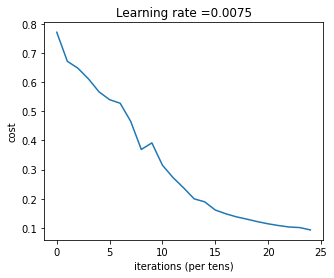


-------------------------------------------------------

the Accuracy on the training set is
Accuracy: 0.9856459330143539

the Accuracy on the test set is
Accuracy: 0.8


In [60]:
parameters = L_layer_model(x_train, y_train, layers_dims, num_iterations=2500, print_cost=True)

print ('\n' + "-------------------------------------------------------" + '\n')  


print("the Accuracy on the training set is")
train_accuracy = predict(x_train, y_train, parameters)
print()
print("the Accuracy on the test set is")
test_accuracy = predict(x_test, y_test, parameters)

## Multiple Plots

The Learning rate is : 0.01

the time required is 61.461509227752686


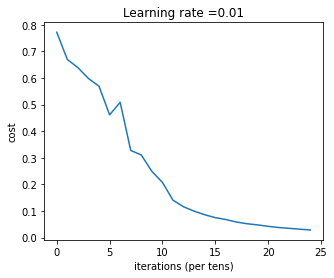

the Accuracy on the training set is
Accuracy: 0.9999999999999998

the Accuracy on the test set is
Accuracy: 0.8400000000000001

-------------------------------------------------------

The Learning rate is : 0.001

the time required is 61.369767904281616


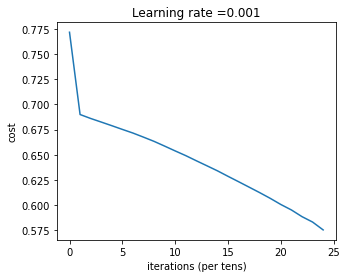

the Accuracy on the training set is
Accuracy: 0.8564593301435406

the Accuracy on the test set is
Accuracy: 0.7

-------------------------------------------------------

The Learning rate is : 0.0001

the time required is 61.645559549331665


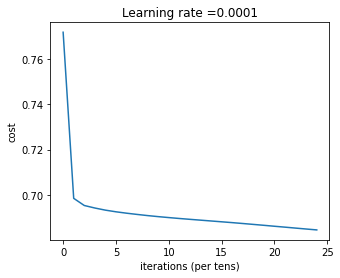

the Accuracy on the training set is
Accuracy: 0.708133971291866

the Accuracy on the test set is
Accuracy: 0.36000000000000004

-------------------------------------------------------



In [63]:
learning_rates = [0.01, 0.001, 0.0001]
for i in learning_rates:
    print("The Learning rate is " + ": " + str(i))
    
    parameters = L_layer_model(x_train, y_train, layers_dims, learning_rate = i,  num_iterations=2500, print_cost=False)
    
    print("the Accuracy on the training set is")
    train_accuracy = predict(x_train, y_train, parameters)
    print()
    print("the Accuracy on the test set is")
    test_accuracy = predict(x_test, y_test, parameters)
    print ('\n' + "-------------------------------------------------------" + '\n')    
    

# Different Initialization

## Zero Initialization

In [65]:
def initialize_parameters_deep_zero(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## Model

In [71]:
def L_layer_model_zero(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    
    start = time.time()
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters_deep_zero(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    end = time.time()
    print("the time required is " + str(end-start))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    parameters
    
    return parameters

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.678011
Cost after iteration 200: 0.667600
Cost after iteration 300: 0.660422
Cost after iteration 400: 0.655458
Cost after iteration 500: 0.652014
Cost after iteration 600: 0.649616
Cost after iteration 700: 0.647942
Cost after iteration 800: 0.646770
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985
the time required is 120.53280925750732


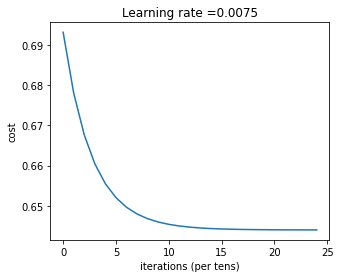


-------------------------------------------------------

the Accuracy on the training set is
Accuracy: 0.6555023923444976

the Accuracy on the test set is
Accuracy: 0.3400000000000001


In [72]:
parameters = L_layer_model_zero(x_train, y_train, layers_dims, num_iterations=2500, print_cost=True)

print ('\n' + "-------------------------------------------------------" + '\n')  


print("the Accuracy on the training set is")
train_accuracy = predict(x_train, y_train, parameters)
print()
print("the Accuracy on the test set is")
test_accuracy = predict(x_test, y_test, parameters)

## Random Initialization

In [66]:
def initialize_parameters_deep_random(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## Model

In [73]:
def L_layer_model_random(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    
    start = time.time()
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters_deep_random(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    end = time.time()
    print("the time required is " + str(end-start))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    parameters
    
    return parameters

Cost after iteration 0: 0.693149
Cost after iteration 100: 0.678010
Cost after iteration 200: 0.667599
Cost after iteration 300: 0.660421
Cost after iteration 400: 0.655457
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649615
Cost after iteration 700: 0.647941
Cost after iteration 800: 0.646769
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644960
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985
the time required is 120.39559364318848


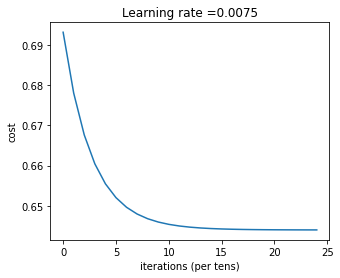


-------------------------------------------------------

the Accuracy on the training set is
Accuracy: 0.6555023923444976

the Accuracy on the test set is
Accuracy: 0.3400000000000001


In [74]:
parameters = L_layer_model_random(x_train, y_train, layers_dims, num_iterations=2500, print_cost=True)

print ('\n' + "-------------------------------------------------------" + '\n')  


print("the Accuracy on the training set is")
train_accuracy = predict(x_train, y_train, parameters)
print()
print("the Accuracy on the test set is")
test_accuracy = predict(x_test, y_test, parameters)

## HE initialization

In [67]:
def initialize_parameters_deep_HE(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) *  np.sqrt(2 / layers_dims[l - 1]) 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [75]:
def L_layer_model_HE(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    
    start = time.time()
    
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters_deep_HE(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    end = time.time()
    print("the time required is " + str(end-start))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    parameters
    
    return parameters

Cost after iteration 0: 1.208125
Cost after iteration 100: 0.674058
Cost after iteration 200: 0.662505
Cost after iteration 300: 0.655233
Cost after iteration 400: 0.650489
Cost after iteration 500: 0.647319
Cost after iteration 600: 0.644942
Cost after iteration 700: 0.643098
Cost after iteration 800: 0.641445
Cost after iteration 900: 0.639893
Cost after iteration 1000: 0.637406
Cost after iteration 1100: 0.635323
Cost after iteration 1200: 0.633421
Cost after iteration 1300: 0.630908
Cost after iteration 1400: 0.627870
Cost after iteration 1500: 0.624349
Cost after iteration 1600: 0.620656
Cost after iteration 1700: 0.616561
Cost after iteration 1800: 0.594951
Cost after iteration 1900: 0.570737
Cost after iteration 2000: 0.539141
Cost after iteration 2100: 0.483494
Cost after iteration 2200: 0.513117
Cost after iteration 2300: 0.388391
Cost after iteration 2400: 0.505814
the time required is 123.941335439682


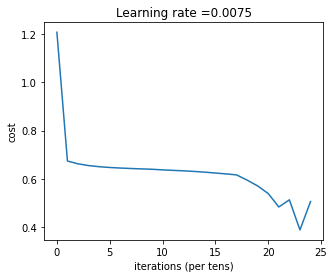


-------------------------------------------------------

the Accuracy on the training set is
Accuracy: 0.9186602870813396

the Accuracy on the test set is
Accuracy: 0.6799999999999999


In [76]:
parameters = L_layer_model_HE(x_train, y_train, layers_dims, num_iterations=2500, print_cost=True)

print ('\n' + "-------------------------------------------------------" + '\n')  


print("the Accuracy on the training set is")
train_accuracy = predict(x_train, y_train, parameters)
print()
print("the Accuracy on the test set is")
test_accuracy = predict(x_test, y_test, parameters)

## Xavier initialization

In [68]:
def initialize_parameters_deep_xavier(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [77]:
def L_layer_model_xavier(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    
    start = time.time()
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters_deep_xavier(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    end = time.time()
    print("the time required is " + str(end-start))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    parameters
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878
the time required is 120.19083881378174


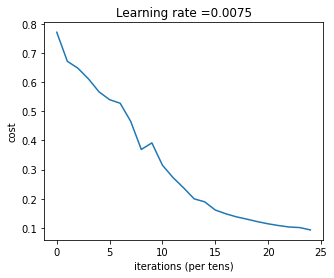


-------------------------------------------------------

the Accuracy on the training set is
Accuracy: 0.9856459330143539

the Accuracy on the test set is
Accuracy: 0.8


In [78]:
parameters = L_layer_model_xavier(x_train, y_train, layers_dims, num_iterations=2500, print_cost=True)

print ('\n' + "-------------------------------------------------------" + '\n')  


print("the Accuracy on the training set is")
train_accuracy = predict(x_train, y_train, parameters)
print()
print("the Accuracy on the test set is")
test_accuracy = predict(x_test, y_test, parameters)

## He and Xavier Initialization

In [69]:
def initialize_parameters_deep_He_and_xavier(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / (layers_dims[l - 1]+ layer_dims[l]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## Model

In [79]:
def L_layer_model_HE_and_xavier(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    
    start = time.time()
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters_deep_He_and_xavier(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    end = time.time()
    print("the time required is " + str(end-start))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    parameters
    
    return parameters

Cost after iteration 0: 0.943145
Cost after iteration 100: 0.670318
Cost after iteration 200: 0.649378
Cost after iteration 300: 0.632884
Cost after iteration 400: 0.577790
Cost after iteration 500: 0.566616
Cost after iteration 600: 0.523302
Cost after iteration 700: 0.478845
Cost after iteration 800: 0.537985
Cost after iteration 900: 0.441654
Cost after iteration 1000: 0.609633
Cost after iteration 1100: 0.384561
Cost after iteration 1200: 0.290132
Cost after iteration 1300: 0.253275
Cost after iteration 1400: 0.213086
Cost after iteration 1500: 0.177392
Cost after iteration 1600: 0.137902
Cost after iteration 1700: 0.119329
Cost after iteration 1800: 0.106048
Cost after iteration 1900: 0.092681
Cost after iteration 2000: 0.083255
Cost after iteration 2100: 0.074371
Cost after iteration 2200: 0.067282
Cost after iteration 2300: 0.062357
Cost after iteration 2400: 0.056449
the time required is 121.85184741020203


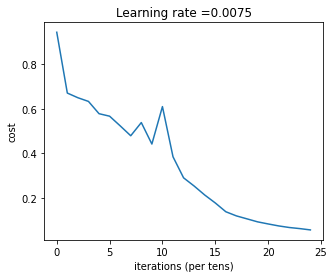


-------------------------------------------------------

the Accuracy on the training set is
Accuracy: 0.9952153110047844

the Accuracy on the test set is
Accuracy: 0.74


In [80]:
parameters = L_layer_model_HE_and_xavier(x_train, y_train, layers_dims, num_iterations=2500, print_cost=True)

print ('\n' + "-------------------------------------------------------" + '\n')  


print("the Accuracy on the training set is")
train_accuracy = predict(x_train, y_train, parameters)
print()
print("the Accuracy on the test set is")
test_accuracy = predict(x_test, y_test, parameters)